<a href="https://colab.research.google.com/github/ThuyLienNguyen/FDSS/blob/main/FDSS_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.89MB/s]

Dataset: MNIST
Optimizer: FDSS


Epoch 1, Loss: 1.72028
Accuracy: 96.40%
Accuracy: 96.37%
Epoch 2, Loss: 1.55787
Accuracy: 97.50%
Accuracy: 97.91%
Epoch 3, Loss: 1.53453
Accuracy: 97.81%
Accuracy: 98.30%
Epoch 4, Loss: 1.52700
Accuracy: 98.01%
Accuracy: 98.66%
Epoch 5, Loss: 1.52229
Accuracy: 98.21%
Accuracy: 98.75%
Epoch 6, Loss: 1.51871
Accuracy: 98.20%
Accuracy: 98.87%
Epoch 7, Loss: 1.51675
Accuracy: 98.23%
Accuracy: 98.95%
Epoch 8, Loss: 1.51507
Accuracy: 98.34%
Accuracy: 98.98%
Epoch 9, Loss: 1.51395
Accuracy: 98.32%
Accuracy: 99.05%
Epoch 10, Loss: 1.51309
Accuracy: 98.36%
Accuracy: 99.09%
Epoch 11, Loss: 1.51222
Accuracy: 98.26%
Accuracy: 99.10%
Epoch 12, Loss: 1.51157
Accuracy: 98.34%
Accuracy: 99.14%
Epoch 13, Loss: 1.51104
Accuracy: 98.41%
Accuracy: 99.19%
Epoch 14, Loss: 1.51051
Accuracy: 98.36%
Accuracy: 99.19%
Epoch 15, Loss: 1.51002
Accuracy: 98.39%
Accuracy: 99.24%
Epoch 16, Loss: 1.50961
Accuracy: 98.39%
Accuracy: 99.22%
Epoch 17, Loss: 1.50918
Accuracy: 98.36%
Accuracy: 99.23%
Epoch 18, Loss: 1.50895

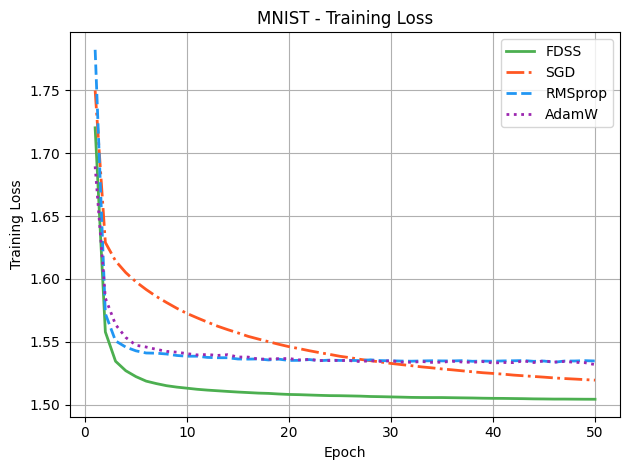

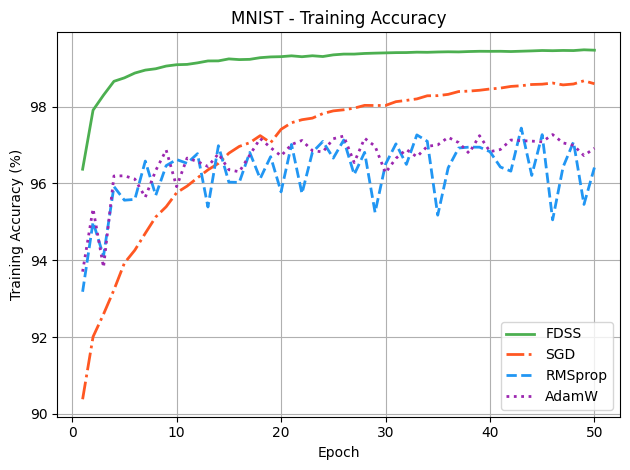

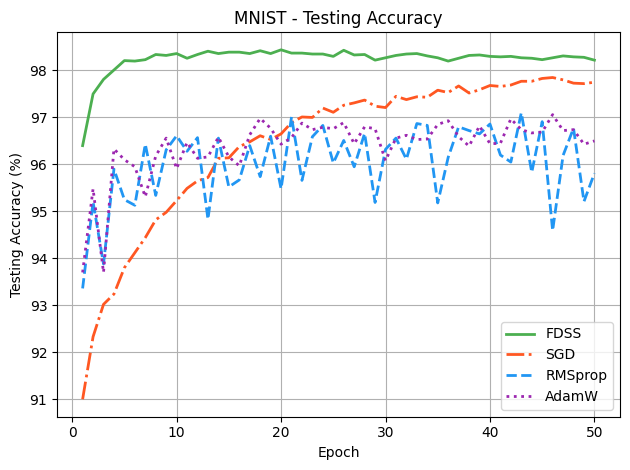

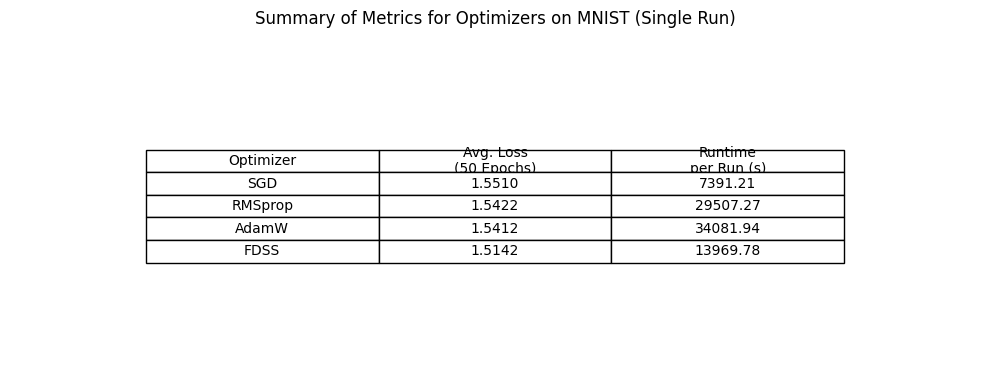

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jun 11 17:21:19 2024

@author: S3894008
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import torch.nn.functional as F
import argparse
from torch.utils.tensorboard import SummaryWriter
import os
import matplotlib.pyplot as plt
import time

parser = argparse.ArgumentParser()
args, unknown = parser.parse_known_args()

# Define a list of line styles
line_styles = [':', '-', '--', '-.']

# --- FDSS Optimizer (with hardcoded params) ---
class FDSS(torch.optim.Optimizer):
    def __init__(self, params):
        # No hyperparameters are passed — everything is fixed inside step()
        defaults = {}
        super().__init__(params, defaults)

    def step(self, closure=None, grad_tmp=None, epoch=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        # Fixed hyperparameters
        lr = 0.001
        alpha = 4
        mu = 1
        l = 0
        h1 = 100
        h2 = 5
        lambda_ = 0.01
        a = 1

        for group in self.param_groups:
            for param, grad in zip(group['params'], grad_tmp):
                if param.grad is None:
                    continue

                state = self.state[param]
                if len(state) == 0:
                    state['u'] = torch.zeros_like(param.data)

                u = state['u']
                psi = max(torch.norm(param.grad), a * torch.norm(param.grad - alpha * u))

                if psi > 0:
                    theta = (h1 / torch.pow(psi, 1/3) * 1 / epoch) + (h2 / torch.pow(psi, -2/3))
                else:
                    theta = 0

                # Update step
                param.data.sub_(lr * u * theta)
                u.add_(lr * (lambda_ * (param.grad - alpha * u) * theta + mu * grad * theta))

                state['u'] = u

        return loss


# --- Models ---
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32 * 26 * 26, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


# --- Utilities ---
def load_dataset(dataset_name):
    if dataset_name == 'MNIST':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
        trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
        batch_size = 64
    elif dataset_name == 'CIFAR10':
        transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
        batch_size = 64
    else:
        raise ValueError(f"Unsupported dataset: {dataset_name}")

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    return trainloader, testloader


def l2_regularization(model, lambda_):
    l2_reg = torch.tensor(0., requires_grad=True)
    for param in model.parameters():
        if param.requires_grad:
            l2_reg = l2_reg + torch.norm(param)**2
    return lambda_ * l2_reg


def test(model, testloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy


def train_and_test(model, trainloader, testloader, criterion, optimizer, device, writer, lambda_, num_epochs=10):
    model.train()
    train_loss_history = []
    test_accuracy_history = []
    train_accuracy_history = []

    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels) + l2_regularization(model, lambda_)
                loss.backward()
                return loss

            loss = closure()
            if isinstance(optimizer, FDSS):
                model_tmp = type(model)()
                model_tmp.load_state_dict(model.state_dict())
                model_tmp.to(device)

                grad_tmp = []
                for param, param_tmp in zip(model.parameters(), model_tmp.parameters()):
                    state = optimizer.state[param]
                    if 'u' not in state:
                        state['u'] = torch.zeros_like(param.data)
                    u = state['u']
                    param_tmp.data = param.data.clone() - 4 * u  # alpha is fixed at 4

                outputs_tmp = model_tmp(inputs)
                loss_tmp = criterion(outputs_tmp, labels) + l2_regularization(model_tmp, lambda_)
                grad_tmp = torch.autograd.grad(loss_tmp, model_tmp.parameters())

                optimizer.step(closure, grad_tmp, epoch=epoch)
            else:
                optimizer.step(closure)

            writer.add_scalar('Loss/train', loss.item(), epoch * len(trainloader) + i)
            running_loss += loss.item()

        epoch_loss = running_loss / len(trainloader)
        train_loss_history.append(epoch_loss)
        print(f"Epoch {epoch}, Loss: {epoch_loss:.5f}")

        test_accuracy = test(model, testloader, device)
        test_accuracy_history.append(test_accuracy)

        train_accuracy = test(model, trainloader, device)
        train_accuracy_history.append(train_accuracy)

    return train_loss_history, test_accuracy_history, train_accuracy_history


import matplotlib.pyplot as plt
import time
import os
from torch.utils.tensorboard import SummaryWriter

# Assuming these are defined elsewhere:
# - load_dataset(dataset_name)
# - CIFAR10_CNN()
# - train_and_test(model, trainloader, testloader, criterion, optimizer, device, writer, lambda_, num_epochs)
# - FDSS (custom optimizer)

# Color mapping for optimizers
colors = {
    'SGD': '#FF5722',
    'RMSprop': '#2196F3',
    'AdamW': '#9C27B0',
    'FDSS': '#4CAF50'
}

# Fixed line styles for consistent ordering
linestyles = {
    'SGD': '-.',
    'RMSprop': '--',
    'AdamW': ':',
    'FDSS': '-'
}

def plot_results(train_loss_histories, train_accuracy_histories, test_accuracy_histories, runtimes, num_epochs, dataset_name):
    img_dir = f"images/{dataset_name}"
    os.makedirs(img_dir, exist_ok=True)

    epochs = range(1, num_epochs + 1)

    # --- Training loss plot ---
    for optim_name, train_loss_history in train_loss_histories.items():
        plt.plot(epochs, train_loss_history, label=optim_name,
                 color=colors[optim_name], linewidth=2, linestyle=linestyles[optim_name])
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.title(f'{dataset_name} - Training Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{img_dir}/epochs{num_epochs}_training_loss.png")
    plt.show()

    # --- Training accuracy plot ---
    for optim_name, train_accuracy_history in train_accuracy_histories.items():
        plt.plot(epochs, train_accuracy_history, label=optim_name,
                 color=colors[optim_name], linewidth=2, linestyle=linestyles[optim_name])
    plt.xlabel('Epoch')
    plt.ylabel('Training Accuracy (%)')
    plt.title(f'{dataset_name} - Training Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{img_dir}/epochs{num_epochs}_train_accuracy.png")
    plt.show()

    # --- Testing accuracy plot ---
    for optim_name, test_accuracy_history in test_accuracy_histories.items():
        plt.plot(epochs, test_accuracy_history, label=optim_name,
                 color=colors[optim_name], linewidth=2, linestyle=linestyles[optim_name])
    plt.xlabel('Epoch')
    plt.ylabel('Testing Accuracy (%)')
    plt.title(f'{dataset_name} - Testing Accuracy')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{img_dir}/epochs{num_epochs}_test_accuracy.png")
    plt.show()

    # --- Summary table with runtime ---
    plt.figure(figsize=(10, 4))
    plt.axis('off')
    table_data = [
        ['Optimizer', 'Avg. Loss\n(50 Epochs)', 'Runtime\nper Run (s)'],
        ['SGD', f"{np.mean(train_loss_histories['SGD']):.4f}", f"{runtimes['SGD']:.2f}"],
        ['RMSprop', f"{np.mean(train_loss_histories['RMSprop']):.4f}", f"{runtimes['RMSprop']:.2f}"],
        ['AdamW', f"{np.mean(train_loss_histories['AdamW']):.4f}", f"{runtimes['AdamW']:.2f}"],
        ['FDSS', f"{np.mean(train_loss_histories['FDSS']):.4f}", f"{runtimes['FDSS']:.2f}"]
    ]
    table = plt.table(cellText=table_data, loc='center', cellLoc='center', colWidths=[0.2, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    plt.title(f'Summary of Metrics for Optimizers on {dataset_name} (Single Run)')
    plt.tight_layout()
    plt.savefig(f"{img_dir}/summary_metrics.png")
    plt.show()


def main():
    # Define parameters
    lambda_ = 0.001
    num_epochs = 50

    torch.manual_seed(1234)
    np.random.seed(1234)
    plt.close('all')

    datasets = ['MNIST']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for dataset_name in datasets:
        trainloader, testloader = load_dataset(dataset_name)
        criterion = nn.CrossEntropyLoss()

        optimizers = [
            ('FDSS', FDSS),
            ('SGD', optim.SGD),
            ('RMSprop', optim.RMSprop),
            ('AdamW', optim.AdamW),
        ]

        print(f"Dataset: {dataset_name}")
        train_loss_histories = {}
        test_accuracy_histories = {}
        train_accuracy_histories = {}
        runtimes = {}

        for optim_name, Optimizer in optimizers:
            print(f"Optimizer: {optim_name}")
            model = ConvNet().to(device)

            if optim_name == 'FDSS':
                optimizer = Optimizer(model.parameters())  # no arguments needed now
                log_dir = f"runs/{dataset_name}/{dataset_name}_FDSS_fixed_params"
            elif optim_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=0.01)
                log_dir = f"runs/{dataset_name}/{dataset_name}_SGD"
            elif optim_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)
                log_dir = f"runs/{dataset_name}/{dataset_name}_RMSprop"
            elif optim_name == 'AdamW':
                optimizer = optim.AdamW(model.parameters(), lr=0.001)
                log_dir = f"runs/{dataset_name}/{dataset_name}_AdamW"
            else:
                raise ValueError(f"Unknown optimizer: {optim_name}")

            writer = SummaryWriter(log_dir=log_dir)

            start_time = time.time()
            train_loss_history, test_accuracy_history, train_accuracy_history = train_and_test(
                model, trainloader, testloader, criterion, optimizer, device, writer, lambda_, num_epochs
            )
            end_time = time.time()
            runtime = end_time - start_time
            runtimes[optim_name] = runtime

            train_loss_histories[optim_name] = train_loss_history
            test_accuracy_histories[optim_name] = test_accuracy_history
            train_accuracy_histories[optim_name] = train_accuracy_history

            writer.close()

        # Return data for plotting
        return train_loss_histories, train_accuracy_histories, test_accuracy_histories, runtimes, num_epochs, dataset_name


if __name__ == '__main__':
    train_loss_histories, train_accuracy_histories, test_accuracy_histories, runtimes, num_epochs, dataset_name = main()
    plot_results(train_loss_histories, train_accuracy_histories, test_accuracy_histories, runtimes, num_epochs, dataset_name)
